# Classifying Using pretrained Models

## 1. Using Feature Extraction

In [1]:
# Loading pre trained VGG
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# Fast feature extraction without data augmentation
*Here we run the VGG model over our dataset and record it's output to a Numpy array,  so this can be used as standalone input to dense layer*.

**Note**: Although it is cheaper to train, we can't use data augmentation here.

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'cats_and_dogs_small_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break                                                           
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
# Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 706us/step - loss: 0.5898 - acc: 0.6675 - val_loss: 0.4341 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 1s 460us/step - loss: 0.4217 - acc: 0.8145 - val_loss: 0.3537 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 490us/step - loss: 0.3626 - acc: 0.8430 - val_loss: 0.3180 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 1s 493us/step - loss: 0.3181 - acc: 0.8630 - val_loss: 0.3004 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 513us/step - loss: 0.2867 - acc: 0.8835 - val_loss: 0.2826 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 1s 503us/step - loss: 0.2631 - acc: 0.8970 - val_loss: 0.2926 - val_acc: 0.8720
Epoch 7/30
2000/2000 [==============================] - 1s 491us/step - loss: 0.2508 - acc: 0.8985 - val_loss: 0.2630 - val_acc: 0.9030


# Overfitting Due to absence of Data Augmentation

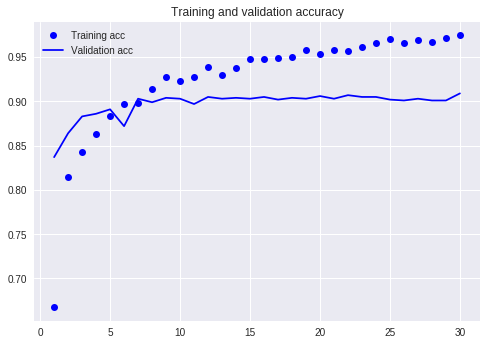

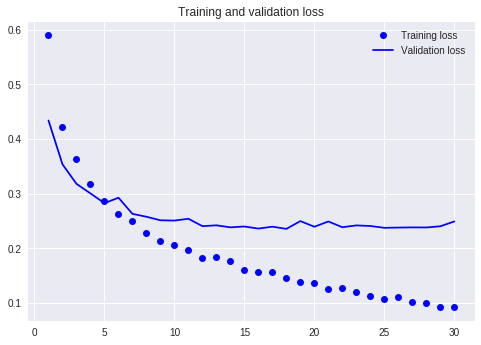

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Feature extraction with data augmentation

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


**Making the VGG models layers not trainable**

In [0]:
conv_base.trainable = False

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                              
        target_size=(150, 150),                                  
        batch_size=20,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 30s 303ms/step - loss: 0.6068 - acc: 0.6705 - val_loss: 0.4480 - val_acc: 0.8370
Epoch 2/20
100/100 [==============================] - 28s 284ms/step - loss: 0.4704 - acc: 0.7965 - val_loss: 0.3553 - val_acc: 0.8680
Epoch 3/20
100/100 [==============================] - 29s 286ms/step - loss: 0.4339 - acc: 0.8030 - val_loss: 0.3334 - val_acc: 0.8660
Epoch 4/20
100/100 [==============================] - 29s 286ms/step - loss: 0.4005 - acc: 0.8215 - val_loss: 0.2956 - val_acc: 0.8870
Epoch 5/20
100/100 [==============================] - 29s 287ms/step - loss: 0.3627 - acc: 0.8515 - val_loss: 0.2826 - val_acc: 0.8830
Epoch 6/20
100/100 [==============================] - 29s 287ms/step - loss: 0.3527 - acc: 0.8485 - val_loss: 0.2797 - val_acc: 0.8830
Epoch 7/20
100/100 [==============================] - 28s 279ms/step - loss: 0.3553 - acc: 0.8490 - val_lo

# No overfitting

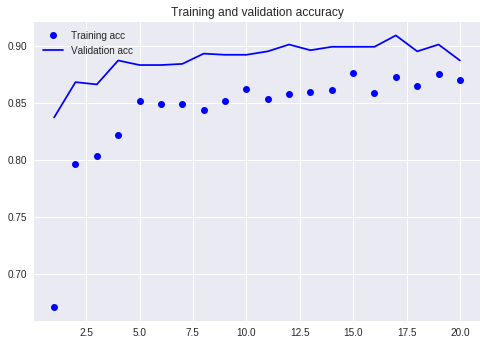

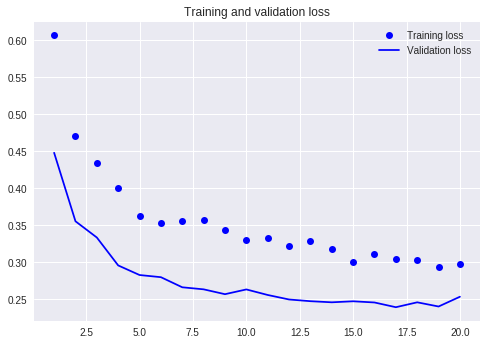

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine Tuning

## Freezing all the layers upto a specific one

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 30s 303ms/step - loss: 0.2971 - acc: 0.8690 - val_loss: 0.2348 - val_acc: 0.9030
Epoch 2/30
100/100 [==============================] - 29s 286ms/step - loss: 0.2632 - acc: 0.8820 - val_loss: 0.1999 - val_acc: 0.9200
Epoch 3/30
100/100 [==============================] - 29s 285ms/step - loss: 0.2256 - acc: 0.9070 - val_loss: 0.2186 - val_acc: 0.9150
Epoch 4/30
100/100 [==============================] - 29s 285ms/step - loss: 0.2321 - acc: 0.9075 - val_loss: 0.2195 - val_acc: 0.9130
Epoch 5/30
100/100 [==============================] - 29s 286ms/step - loss: 0.2008 - acc: 0.9150 - val_loss: 0.1996 - val_acc: 0.9240
Epoch 6/30
100/100 [==============================] - 29s 285ms/step - loss: 0.2045 - acc: 0.9135 - val_loss: 0.1862 - val_acc: 0.9300
Epoch 7/30
100/100 [==============================] - 29s 285ms/step - loss: 0.1890 - acc: 0.9200 - val_loss: 0.1751 - val_acc: 0.9290
Epoch 8/30
100/100 [==============================] - 2

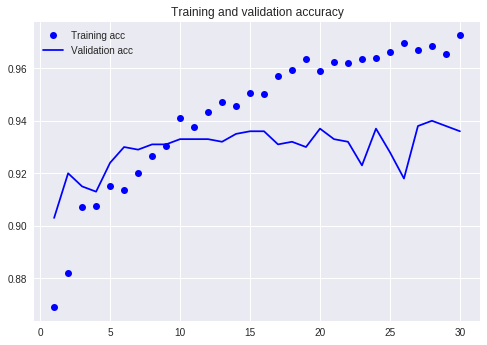

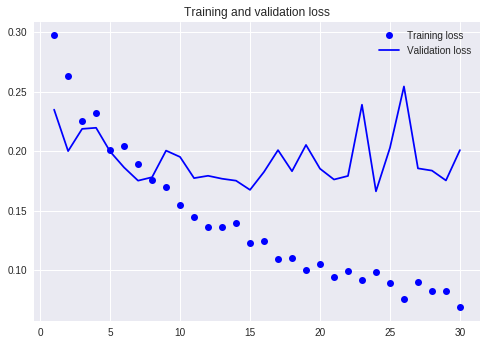

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Smoothing the plots**

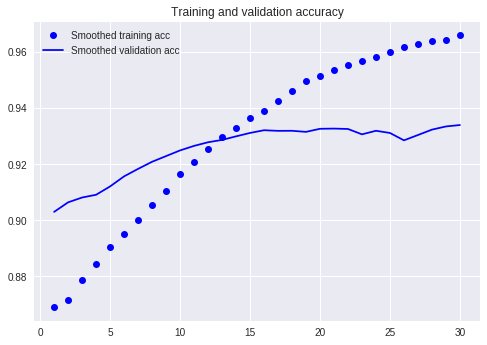

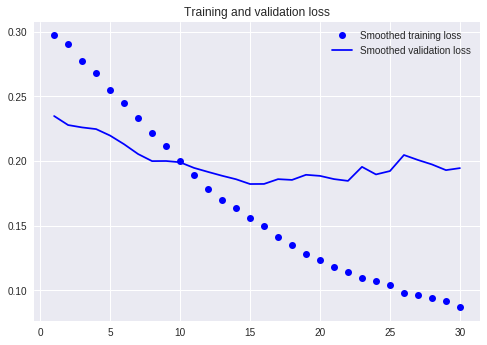

In [17]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9349999940395355


In [0]:
model.save('cats_and_dogs_small_.h5')